<a href="https://colab.research.google.com/github/ariegever/ImageProcessing_Project/blob/main/4_unet_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#=== HOW TO USE THIS NOTEBOOK ===
#
# 1.  **Set Runtime:** Go to "Runtime" > "Change runtime type" and select
#     "T4 GPU" (or any available GPU) as the "Hardware accelerator".
#     This is *critical* for training your model.
#
# 2.  **Run Cell 2 (Mount Drive)**
#
# 3.  **Run Cell 3 (Install Libraries)**
#
# 4.  **Fill in "Cell 5: USER CONFIGURATION":**
#     * You MUST provide your:
#         * GCP Project ID.
#         * The **same Google Drive path** you used in the data generation notebook.
#         * The **same asset paths** you used before.
#
# 5.  **Run "Cell 6: Upload class_definitions.json":**
#     * Upload your class definition file (the one with class names, colors,
#       and values) just as you did before.
#
# 6.  **Run All Remaining Cells:**
#     * The notebook will load your class definitions, prepare the data
#       pipeline, build your U-Net model, and start training.
#     * Training will take some time.
#     * After training, it will plot the history, show a classification
#       report, and save your final model to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
import google.auth
import ee
# Trigger the authentication flow.
auth.authenticate_user()
PROJECT = "ivory-scion-476708-t5"
# Get credentials and initialize Earth Engine
credentials, project = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

print(f"Successfully initialized Earth Engine for project: {PROJECT}")
!pip install  scikit-learn scikit-image rasterio
!pip install keres

import json
import os
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
import tensorflow as keras
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Input, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn for metrics
# We will add cohen_kappa_score here
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score

# Matplotlib helpers
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from skimage.exposure import rescale_intensity

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully initialized Earth Engine for project: ivory-scion-476708-t5
  Using cached keres-0.8.5.tar.gz (541 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# === 1. Google Cloud Project ===

PROJECT = 'ivory-scion-476708-t5'  # <-- 1. REPLACE with your GCP Project ID

# --- 2. Google Drive Path ---

# This MUST be the same path you used in the data generation notebook
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images' # <-- 2. REPLACE IF YOU WANT

# --- 3. Earth Engine Asset Paths (for reference) ---
# These are not used for training, but are good to keep for prediction
S2_ASSET_PATH = 'projects/ivory-scion-476708-t5/assets/east_negev_Sentinel2_2020' # <-- 3. REPLACE
S1_ASSET_PATH = 'projects/ivory-scion-476708-t5/assets/east_negev_Sentinel1_2020' # <-- 4. REPLACE
YEAR = 2020 # <-- 4. REPLACE

# --- 4. Band Definitions ---
#
#
S2_BANDS = [
     'B2', 'B3', 'B4', 'B8', 'B11', 'B12'
]
S1_BANDS = [
    'VV', 'VH'
]
#
# These are created automatically:
FEATURE_NAMES = S2_BANDS + S1_BANDS
LABEL_NAME = 'label'
NUM_BANDS = len(FEATURE_NAMES) # e.g., 14

# --- 5. File Paths ---
CLASS_JSON_PATH = '/content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/lcs/dict_land_cover.json'

# This is the TFRecord file we created in the last notebook
TFRECORD_FILE_PATH = os.path.join(DRIVE_PROJECT_PATH, f'S2_S1_patches_{YEAR}.tfrecord.gz')
HISTORY_CSV_PATH = os.path.join(DRIVE_PROJECT_PATH, 'training_history.csv')

# This is where your final trained model will be saved
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_PATH, 'unet_s1_s2_model_v1.keras')
LATEST_CHECKPOINT_PATH = os.path.join(DRIVE_PROJECT_PATH, 'latest_checkpoint.weights.h5')
BEST_CHECKPOINT_PATH = os.path.join(DRIVE_PROJECT_PATH, 'best_checkpoint.weights.h5')
# --- 6. Model Training Parameters ---
PATCH_SIZE = 128
BUFFER_SIZE = 1000  # For shuffling the dataset
BATCH_SIZE = 16
EPOCHS = 100
TRAIN_SPLIT = 0.8  # 80% for training, 10% for validation, 10% for test
VAL_SPLIT = 0.1

print(f"--- Configuration ---")
print(f"Project: {PROJECT}")
print(f"TFRecord File: {TFRECORD_FILE_PATH}")
print(f"Model Save Path: {MODEL_SAVE_PATH}")
print(f"Input Bands ({NUM_BANDS}): {FEATURE_NAMES}")
print(f"Batch Size: {BATCH_SIZE}")

--- Configuration ---
Project: ivory-scion-476708-t5
TFRecord File: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/S2_S1_patches_2020.tfrecord.gz
Model Save Path: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/unet_s1_s2_model_v1.keras
Input Bands (8): ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'VV', 'VH']
Batch Size: 16


In [ ]:
import json
import pandas as pd
from matplotlib.colors import ListedColormap

# 1. Load the JSON
try:
    with open(CLASS_JSON_PATH) as f:
        lc = json.load(f)
except FileNotFoundError:
    print(f"ERROR: '{CLASS_JSON_PATH}' not found.")
    raise
except json.JSONDecodeError:
    print(f"ERROR: '{CLASS_JSON_PATH}' is not a valid JSON file.")
    raise


# 2. Create DataFrame for the Main Classes (Parent Groups)
lc_df = pd.DataFrame.from_dict(lc, orient='index')
lc_df = lc_df.rename(columns={'class': 'label', 'color': 'palette'})

# Define the target values (e.g., 1, 2, 3...)
lc_df["target_value"] = lc_df.index.astype(int) + 1

# 3. Flatten the nested data to create 'from_values' and 'to_values'
# We map the specific IDs (11, 21) to the PARENT ID (1, 2)
from_values = []
to_values = []

for index, row in lc_df.iterrows():
    target = row['target_value']
    for item in row['original_classes']:
        from_values.append(item['values']) # e.g. 21
        to_values.append(target)       # e.g. 2

# 4. Setup Palette and Visuals for 5 Classes
class_labels = lc_df["label"].to_list()
palette_hex = lc_df["palette"].to_list()
cmap = ListedColormap(palette_hex)
NUM_CLASSES = len(lc_df) + 1
vmin = 0
vmax = len(class_labels)

print(f"Reduced complexity: Mapping {len(from_values)} specific types to {len(lc_df)} parent classes.")
lc_df

Reduced complexity: Mapping 12 specific types to 5 parent classes.


,label,palette,values_normalize,original_classes,target_value
0,Built-up,#E60000,0,"[{'class': 'Built up and road surface', 'color...",1
1,Disturbed,#B22222,1,"[{'class': 'Transportation disturbed', 'color'...",2
2,Natural and wooded,#006400,2,"[{'class': 'Natural', 'color': '#006400', 'val...",3
3,Agriculture,#ADFF2F,3,"[{'class': 'Cropland', 'color': '#ADFF2F', 'va...",4
4,Water,#0000FF,4,"[{'class': 'Natural water surface', 'color': '...",5


In [ ]:
# --- 1. Define the Parser Function ---
def parse_tfrecord(example_proto):
    kernel_shape = [PATCH_SIZE, PATCH_SIZE]
    features_dict = {}

    for f in FEATURE_NAMES:
        features_dict[f] = tf.io.FixedLenFeature(shape=kernel_shape, dtype=tf.float32)
    features_dict[LABEL_NAME] = tf.io.FixedLenFeature(shape=kernel_shape, dtype=tf.int64)

    parsed_features = tf.io.parse_single_example(example_proto, features_dict)

    for f in FEATURE_NAMES:

        parsed_features[f] = tf.clip_by_value(parsed_features[f], 0.0, 1.0)

    return parsed_features

# --- 2. Define Data Augmentation Function ---
# This will be applied to the training set ONLY
def augment_data(features, label):
    # Randomly flip left-right
    if tf.random.uniform(()) > 0.5:
        features = tf.image.flip_left_right(features)
        label = tf.image.flip_left_right(label)

    # Randomly flip up-down
    if tf.random.uniform(()) > 0.5:
        features = tf.image.flip_up_down(features)
        label = tf.image.flip_up_down(label)

    # Random 90-degree rotation
    # k = 0, 1, 2, or 3 rotations
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    features = tf.image.rot90(features, k)
    label = tf.image.rot90(label, k)

    return features, label

# --- 3. Define Final Formatting Function ---
# This stacks the features and one-hot encodes the label
def format_data(parsed_features):
    # Stack all feature bands into one tensor
    feature_tensors = [parsed_features[f] for f in FEATURE_NAMES]
    features = tf.stack(feature_tensors, axis=-1)

    # Get the label
    label = parsed_features[LABEL_NAME]

    # One-hot encode the label
    # The label is [128, 128], depth is NUM_CLASSES
    label_one_hot = tf.one_hot(label, depth=NUM_CLASSES)

    # Squeeze out the extra dimension (if any)
    # Shape might be [128, 128, 1, NUM_CLASSES] -> [128, 128, NUM_CLASSES]
    if label_one_hot.shape.rank == 4:
        label_one_hot = tf.squeeze(label_one_hot, axis=-2)

    # Cast to float32 for the model
    label_one_hot = tf.cast(label_one_hot, tf.float32)

    return features, label_one_hot

# --- 4. Create the Full Dataset Pipeline ---
def create_dataset(tfrecord_path, is_training=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")

    # Parse the records
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    # Format: stack features, one-hot label
    dataset = dataset.map(format_data, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        # Only apply augmentation and shuffling to training data
        dataset = dataset.shuffle(BUFFER_SIZE)
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

print("TFRecord data pipeline functions defined.")

TFRecord data pipeline functions defined.


In [ ]:
# --- 1. Count the total number of samples ---
print(f"Counting samples in {TFRECORD_FILE_PATH}...")
count_ds = tf.data.TFRecordDataset(TFRECORD_FILE_PATH, compression_type="GZIP")
total_samples = 0
for _ in count_ds:
    total_samples += 1

print(f"Total samples found: {total_samples}")

# --- 2. Define splits ---
train_size = int(total_samples * TRAIN_SPLIT)
val_size = int(total_samples * VAL_SPLIT)
test_size = total_samples - train_size - val_size

# --- 3. Calculate steps ---
# We must use these in model.fit() when using .repeat()
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = val_size // BATCH_SIZE

print(f"Training samples: {train_size} (-> {steps_per_epoch} steps/epoch)")
print(f"Validation samples: {val_size} (-> {validation_steps} steps)")
print(f"Test samples: {test_size}")


# --- 4. Create the full dataset and split it ---
full_dataset = tf.data.TFRecordDataset(TFRECORD_FILE_PATH, compression_type="GZIP")


# Shuffle the *entire* dataset *before* splitting and parsing.
# This shuffles the small, raw TFRecord strings, which uses very little RAM.
# We set buffer_size to total_samples for a "perfect" shuffle.
full_dataset = full_dataset.shuffle(total_samples, reshuffle_each_iteration=True)


# Split
train_ds_raw = full_dataset.take(train_size)
val_ds_raw = full_dataset.skip(train_size).take(val_size)
test_ds_raw = full_dataset.skip(train_size + val_size)

# --- 5. Apply the data pipelines ---
train_dataset = train_ds_raw.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(format_data, num_parallel_calls=tf.data.AUTOTUNE)
# We add a small, safe shuffle buffer *after* parsing to mix the batches.
train_dataset = train_dataset.shuffle(200)
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat() # Add .repeat() for training

val_dataset = val_ds_raw.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(format_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat() # Add .repeat() for validation

# Test dataset does NOT need .repeat()
test_dataset = test_ds_raw.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(format_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


print("\nDatasets successfully created.")
print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")
print(f"Test Dataset: {test_dataset}")

Counting samples in /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/S2_S1_patches_2020.tfrecord.gz...
Total samples found: 2535
Training samples: 2028 (-> 126 steps/epoch)
Validation samples: 253 (-> 15 steps)
Test samples: 254

Datasets successfully created.
Train Dataset: <_RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None))>
Validation Dataset: <_RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None))>


In [ ]:
for images, labels in train_dataset.take(1):
    print(f"Max value in image: {np.max(images[0])}")
    print(f"Min value in image: {np.min(images[0])}")
    print(f"Mean value in image: {np.mean(images[0])}")

    # If Max is > 1.0 or Mean is near 0.0, your normalization is wrong.

Max value in image: 1.0
Min value in image: 0.0
Mean value in image: 0.23877571523189545


In [ ]:
# Make keras model
# Set input shape from our config variables
input_shape = (PATCH_SIZE, PATCH_SIZE, NUM_BANDS)

neuron = 32
kernel = 3
kernel_t = 2
dropout = 0.2
strides = 2
pool = 2
padding = 'same'

input_layer = Input(input_shape)

def conv2_block(input, neuron, last=False):
	conv1 = Conv2D(neuron, kernel, activation='relu', padding=padding)(input)
	conv2 = Conv2D(neuron, kernel, activation='relu', padding=padding)(conv1)
	return conv2

def encode(input, neuron):
	conv1 = conv2_block(input, neuron)
	mp = MaxPooling2D(2)(conv1)
	dp = Dropout(dropout)(mp)
	return conv1, dp

def decode(input, conv, neuron):
	conv_t = Conv2DTranspose(neuron, kernel_t, strides, activation='relu', padding=padding)(input)
	concat = concatenate([conv_t, conv])
	conv2 = conv2_block(concat, neuron)
	dp = Dropout(dropout)(conv2)
	return dp

conv1, mp1 = encode(input_layer, neuron * 1)
conv2, mp2 = encode(mp1, neuron * 2)
conv3, mp3 = encode(mp2, neuron * 4)
conv4, mp4 = encode(mp3, neuron * 8)

transition = conv2_block(mp4, neuron * 16)

uncov1 = decode(transition, conv4, neuron * 8)
uncov2 = decode(uncov1, conv3, neuron * 4)
uncov3 = decode(uncov2, conv2, neuron * 2)
uncov4 = decode(uncov3, conv1, neuron * 1)

# Set the final output units to NUM_CLASSES
output = Conv2D(NUM_CLASSES, 1, padding=padding, activation='softmax')(uncov4)

model = Model(input_layer, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,336 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 256) │          0 │ max_pooling2d_3[

 Total params: 7,761,702 (29.61 MB)

 Trainable params: 7,761,702 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Import the new callback
from keras.callbacks import CSVLogger
from keras.callbacks import ReduceLROnPlateau

ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# Compile and build the model
model.compile(
	optimizer=keras.optimizers.Adam(0.0001),
	loss=keras.losses.CategoricalCrossentropy(),
	metrics=[
        keras.metrics.CategoricalAccuracy()
    ]
)

# --- THIS IS THE FIX ---
initial_epoch = 0
weights_loaded = False

# Check if the history CSV file exists
if os.path.exists(HISTORY_CSV_PATH):
    try:
        # Load the history
        history_df = pd.read_csv(HISTORY_CSV_PATH)
        # Get the last epoch number and add 1
        initial_epoch = history_df['epoch'].iloc[-1] + 1
        print(f"Found history file. Will resume from epoch {initial_epoch}.")
    except Exception as e:
        print(f"Warning: Could not read history.csv, will start epoch counter from 0. Error: {e}")
        initial_epoch = 0

# --- NEW ROBUST LOADING LOGIC ---
# First, try to load the LATEST checkpoint
try:
    if os.path.exists(LATEST_CHECKPOINT_PATH):
        print(f"Loading weights from LATEST checkpoint: {LATEST_CHECKPOINT_PATH}...")
        model.load_weights(LATEST_CHECKPOINT_PATH)
        print("Latest weights loaded successfully.")
        weights_loaded = True
    else:
        print("No 'latest' checkpoint found.")
except Exception as e:
    # This will catch the "bad object header" error
    print(f"Warning: Could not load LATEST checkpoint. File may be corrupt. Error: {e}")
    weights_loaded = False

# If loading LATEST failed, try to load the BEST checkpoint
if not weights_loaded:
    try:
        if os.path.exists(BEST_CHECKPOINT_PATH):
            print(f"Attempting to load weights from BEST checkpoint: {BEST_CHECKPOINT_PATH}...")
            model.load_weights(BEST_CHECKPOINT_PATH)
            print("Best weights loaded successfully.")
            weights_loaded = True
        else:
            print("No 'best' checkpoint found either.")
    except Exception as e:
        print(f"Warning: Could not load BEST checkpoint. Error: {e}")

if not weights_loaded:
     print("No valid checkpoints found. Training from scratch.")
# --- END OF FIX ---


callbacks = [
    EarlyStopping(patience=10, monitor='val_categorical_accuracy', mode='max', restore_best_weights=True),
    ModelCheckpoint(filepath=BEST_CHECKPOINT_PATH, save_best_only=True, save_weights_only=True, monitor='val_categorical_accuracy', mode='max'),
    ModelCheckpoint(filepath=LATEST_CHECKPOINT_PATH, save_best_only=False, save_weights_only=True),
    CSVLogger(HISTORY_CSV_PATH, append=True)
]

print("\n--- Starting Model Training ---")

# Train the model
result = model.fit(
	train_dataset,
	epochs=EPOCHS,
	initial_epoch=initial_epoch, # Tell the model where to start counting
	steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
	validation_data=val_dataset,
	callbacks=callbacks
)

print("--- Model Training Complete ---")
print(f"Best model weights saved to {BEST_CHECKPOINT_PATH}")

Found history file. Will resume from epoch 92.
Loading weights from LATEST checkpoint: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/latest_checkpoint.weights.h5...
Latest weights loaded successfully.

--- Starting Model Training ---
Epoch 93/100


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - categorical_accuracy: 0.7730 - loss: 0.6076 - val_categorical_accuracy: 0.7612 - val_loss: 0.6341
Epoch 94/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - categorical_accuracy: 0.7599 - loss: 0.6535 - val_categorical_accuracy: 0.7559 - val_loss: 0.6182
Epoch 95/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 230ms/step - categorical_accuracy: 0.7648 - loss: 0.6168 - val_categorical_accuracy: 0.7837 - val_loss: 0.5552
Epoch 96/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - categorical_accuracy: 0.7691 - loss: 0.6089 - val_categorical_accuracy: 0.7265 - val_loss: 0.6945
Epoch 97/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - categorical_accuracy: 0.7602 - loss: 0.6294 - val_categorical_accuracy: 0.7848 - val_loss: 0.5486
Epoch 98/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 388ms/step - categorical_accuracy: 0.7724 - loss: 0.5990 - val_categorical_accuracy: 0.7929 - val_loss: 0.5277
Epoch 99/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - categorical_

--- DIAGNOSTIC REPORT ---
Label Shape: (16, 128, 128)
Unique values found in these labels: [1 2 3 4 5]
Percentage of 'Background' (Class 0) pixels: 0.00%


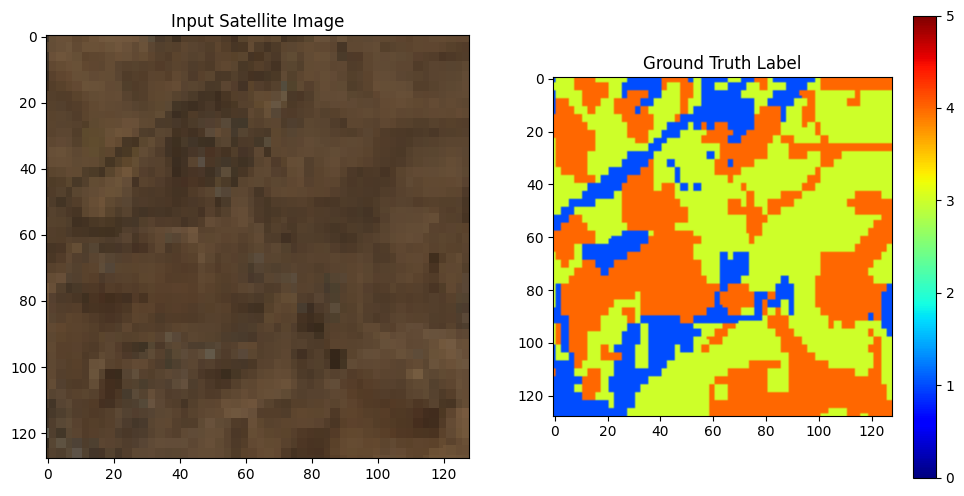

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Grab one batch from the TRAIN dataset (not test)
for images, labels in train_dataset.take(1):

    # 2. Check the VALUES in the label
    # We convert one-hot back to integers (0, 1, 2, 3, 4, 5)
    label_indices = tf.argmax(labels, axis=-1).numpy()

    print(f"--- DIAGNOSTIC REPORT ---")
    print(f"Label Shape: {label_indices.shape}")
    print(f"Unique values found in these labels: {np.unique(label_indices)}")

    # Calculate how much of the image is Class 0 (Background/Empty)
    total_pixels = label_indices.size
    background_pixels = np.sum(label_indices == 0)
    print(f"Percentage of 'Background' (Class 0) pixels: {(background_pixels/total_pixels)*100:.2f}%")

    # 3. PLOT THEM
    plt.figure(figsize=(12, 6))

    # Plot Image 1 (RGB)
    plt.subplot(1, 2, 1)
    # Try to grab RGB (assuming indices 0, 1, 2 are B2, B3, B4 or similar)
    # We reverse the order to make B4,B3,B2 -> RGB
    rgb_img = np.stack([images[0,:,:,2], images[0,:,:,1], images[0,:,:,0]], axis=-1)
    plt.imshow(np.clip(rgb_img, 0, 1)) # Clip just in case
    plt.title("Input Satellite Image")

    # Plot Label 1
    plt.subplot(1, 2, 2)
    plt.imshow(label_indices[0], cmap='jet', vmin=0, vmax=5)
    plt.title("Ground Truth Label")
    plt.colorbar()

    plt.show()
    break

Loaded full training history from CSV:
    epoch  categorical_accuracy      loss  val_categorical_accuracy  val_loss
95     95              0.771422  0.607412                  0.726511  0.694520
96     96              0.766053  0.618506                  0.784776  0.548629
97     97              0.772985  0.597007                  0.792904  0.527748
98     98              0.774409  0.593279                  0.772958  0.610924
99     99              0.771365  0.605492                  0.779543  0.569564
Training history plot saved to /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/training_history_full.png


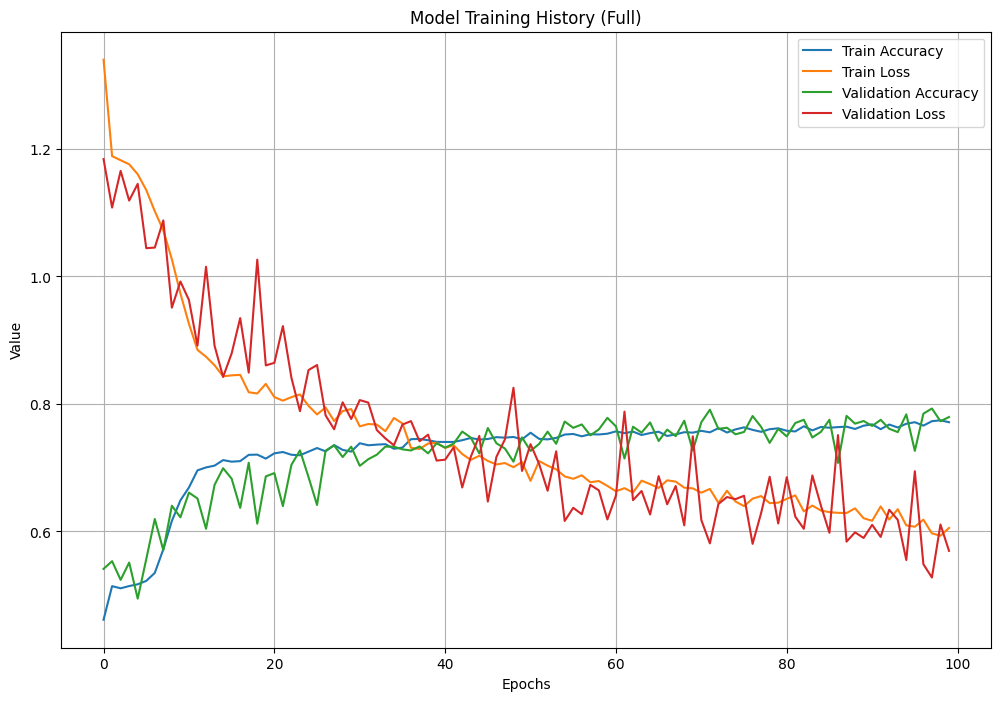

In [ ]:
import pandas as pd
# This ensures the plot shows all epochs, even across restarts.
try:
    history = pd.read_csv(HISTORY_CSV_PATH)
    print("Loaded full training history from CSV:")
    print(history.tail()) # Print the last 5 rows
except FileNotFoundError:
    print("History CSV not found. Plotting history from *this session only*.")
    # Fallback to the current session's history
    history = pd.DataFrame(result.history)
    history['epoch'] = history.index
except pd.errors.EmptyDataError:
    print("History CSV is empty. Plotting history from *this session only*.")
    history = pd.DataFrame(result.history)
    history['epoch'] = history.index
except Exception as e:
    print(f"Error reading history CSV: {e}. Plotting history from *this session only*.")
    history = pd.DataFrame(result.history)
    history['epoch'] = history.index
# --- END OF FIX ---


plt.figure(figsize = (12, 8))

# Use the 'epoch' column from the CSV for the x-axis
plt.plot(history['epoch'], history['categorical_accuracy'], label = 'Train Accuracy')
plt.plot(history['epoch'], history['loss'], label = 'Train Loss')
plt.plot(history['epoch'], history['val_categorical_accuracy'], label = 'Validation Accuracy')
plt.plot(history['epoch'], history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Model Training History (Full)')
plt.legend()
plt.grid(True)

# Save the plot to your Google Drive so it persists
history_plot_path = os.path.join(DRIVE_PROJECT_PATH, 'training_history_full.png')
plt.savefig(history_plot_path)
print(f"Training history plot saved to {history_plot_path}")

plt.show()

Refreshed Class Definitions: 5 classes found.
Expecting labels: [1, 2, 3, 4, 5]
Labels: ['Built-up', 'Disturbed', 'Natural and wooded', 'Agriculture', 'Water']

--- Re-evaluating on Test Set ---

Cohen's Kappa Score: 0.6576

Classification Report:
                    precision    recall  f1-score   support

          Built-up       0.67      0.66      0.67    420583
         Disturbed       0.56      0.12      0.20     82302
Natural and wooded       0.84      0.86      0.85   2203564
       Agriculture       0.78      0.79      0.79   1309897
             Water       0.00      0.00      0.00       766

         micro avg       0.80      0.80      0.80   4017112
         macro avg       0.57      0.49      0.50   4017112
      weighted avg       0.80      0.80      0.80   4017112

Generating Confusion Matrix...


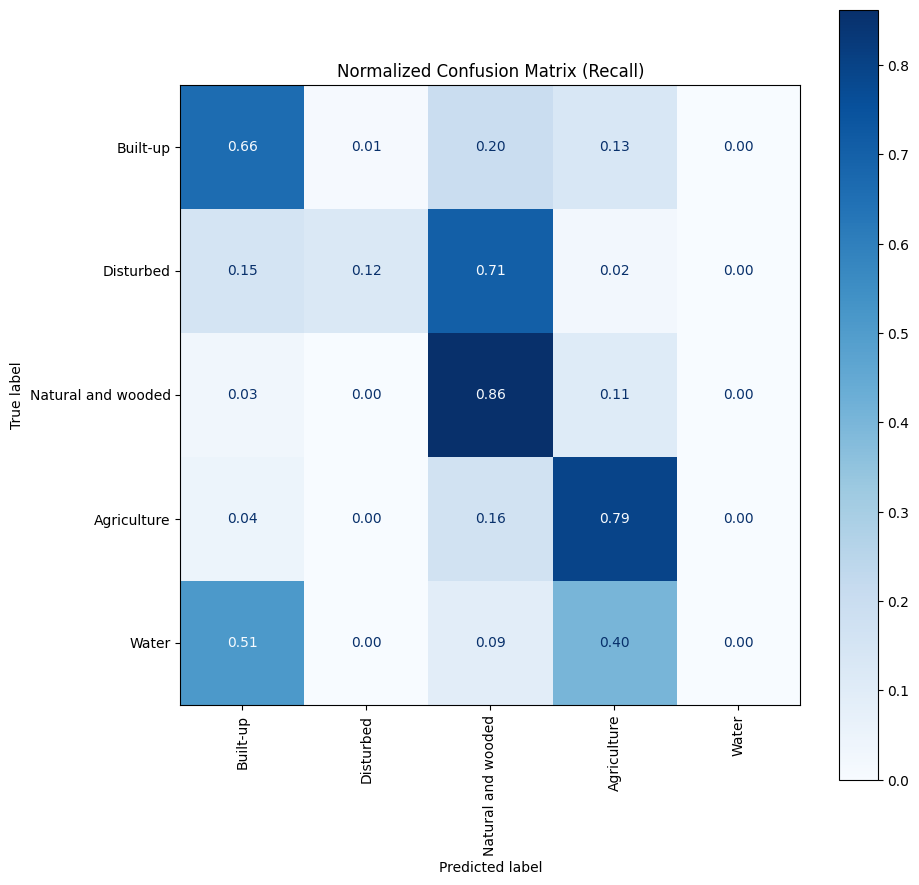

In [ ]:
# --- 1. RESET CLASS DEFINITIONS (5 Classes) ---
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the JSON again
with open(CLASS_JSON_PATH) as f:
    lc = json.load(f)

# Create DataFrame for the 5 Parent Classes
lc_df = pd.DataFrame.from_dict(lc, orient='index')
lc_df = lc_df.rename(columns={'class': 'label', 'color': 'palette'})

# Create Target Values (1, 2, 3, 4, 5)
lc_df["values_normalize"] = lc_df.index.astype(int) + 1

# Prepare lists for Evaluation
# NOTE: We use the simple 1-5 mapping because your data is already aggregated
to_values = lc_df["values_normalize"].to_list()  # [1, 2, 3, 4, 5]
class_labels = lc_df["label"].to_list()          # ["Built-up", "Disturbed", ...]
palette_hex = lc_df["palette"].to_list()
cmap = ListedColormap(palette_hex)

print(f"Refreshed Class Definitions: {len(class_labels)} classes found.")
print(f"Expecting labels: {to_values}")
print(f"Labels: {class_labels}")

# --- 2. RE-EVALUATE MODEL ---
print("\n--- Re-evaluating on Test Set ---")

y_pred_all = []
y_true_all = []

# Loop through test dataset
for features, labels in test_dataset:
    # Get true labels (index)
    y_true_batch = tf.argmax(labels, axis=-1)
    y_true_all.append(y_true_batch.numpy().flatten())

    # Get predictions (index)
    predictions = model.predict(features, verbose=0)
    y_pred_batch = tf.argmax(predictions, axis=-1)
    y_pred_all.append(y_pred_batch.numpy().flatten())

# Concatenate
y_true_flat = np.concatenate(y_true_all)
y_pred_flat = np.concatenate(y_pred_all)

# Filter out background (0)
valid_indices = y_true_flat != 0
y_true_filtered = y_true_flat[valid_indices]
y_pred_filtered = y_pred_flat[valid_indices]

# Calculate Kappa
kappa = cohen_kappa_score(y_true_filtered, y_pred_filtered, labels=to_values)
print(f"\nCohen's Kappa Score: {kappa:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true_filtered,
    y_pred_filtered,
    labels=to_values,
    target_names=class_labels,
    zero_division=0
))

# Confusion Matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(
    y_true_filtered,
    y_pred_filtered,
    labels=to_values,
    normalize='true' # Normalizes rows (Recall)
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', values_format='.2f')
plt.title('Normalized Confusion Matrix (Recall)')
plt.show()

--- Plotting Example Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Example predictions saved to /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/example_predictions.png


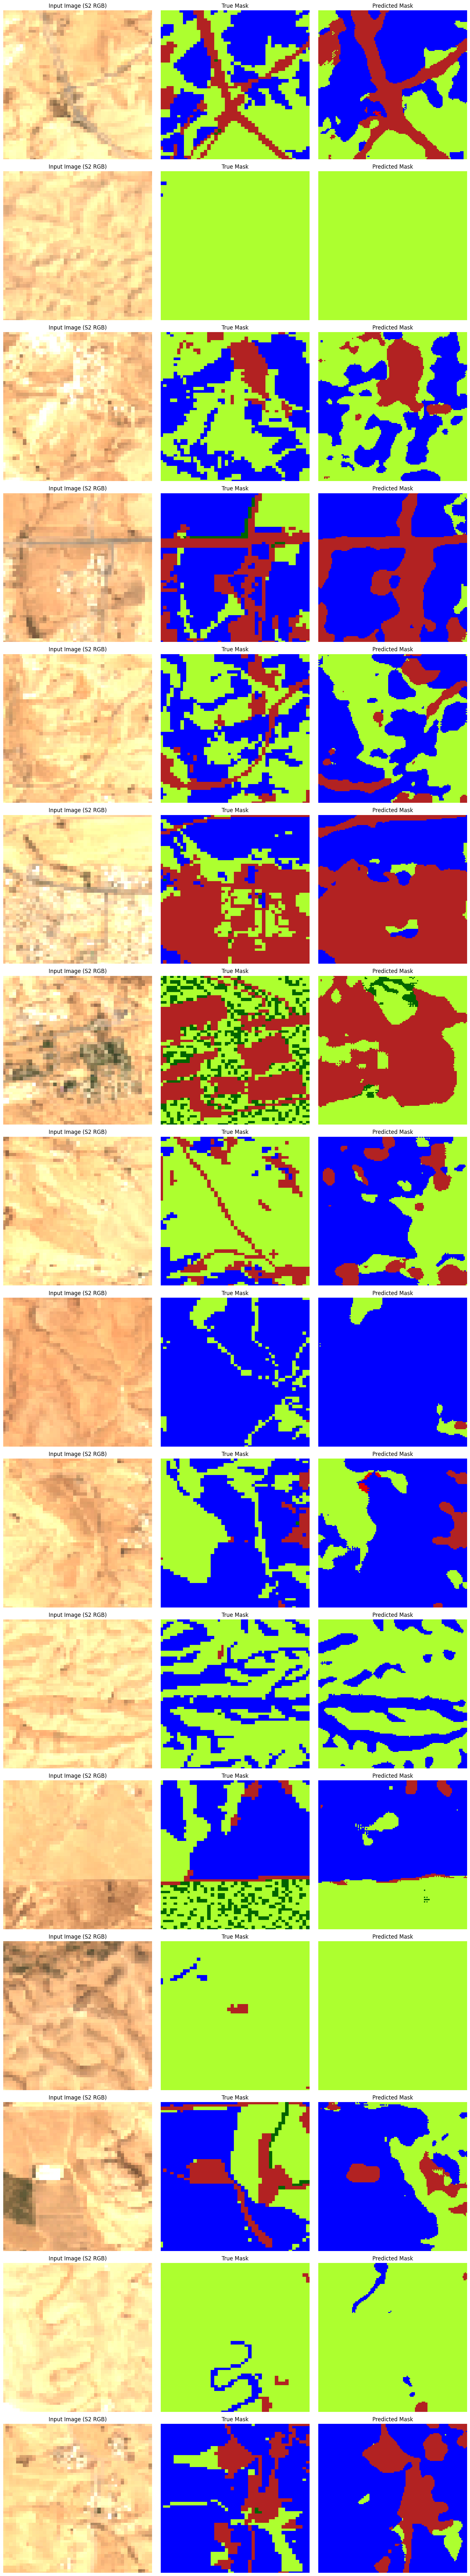

In [ ]:

print("--- Plotting Example Predictions ---")

# Get one batch from the test dataset
for test_images, test_masks_one_hot in test_dataset.take(1):

    # Get model predictions
    pred_masks_one_hot = model.predict(test_images)

    # Convert one-hot back to class indices
    pred_masks = tf.argmax(pred_masks_one_hot, axis=-1).numpy()
    true_masks = tf.argmax(test_masks_one_hot, axis=-1).numpy()

    # Plot
    plt.figure(figsize=(15, 5 * BATCH_SIZE))

    for i in range(BATCH_SIZE):
        # --- S2 RGB Composite for plotting ---
        try:
            # --- THIS IS THE FIX ---
            # We must convert the tensor to a numpy array with .numpy()
            # before passing it to scikit-image's rescale_intensity
            red_data = test_images[i, :, :, S2_BANDS.index('B4')].numpy()
            green_data = test_images[i, :, :, S2_BANDS.index('B3')].numpy()
            blue_data = test_images[i, :, :, S2_BANDS.index('B2')].numpy()

            red = rescale_intensity(red_data, in_range=(0.0, 0.3), out_range=(0, 1))
            green = rescale_intensity(green_data, in_range=(0.0, 0.3), out_range=(0, 1))
            blue = rescale_intensity(blue_data, in_range=(0.0, 0.3), out_range=(0, 1))
            # --- END OF FIX ---

            s2_rgb = np.dstack([red, green, blue])
        except ValueError:
             s2_rgb = np.zeros((PATCH_SIZE, PATCH_SIZE, 3)) # In case B2/3/4 aren't in S2_BANDS
        except KeyError:
             print("Warning: Could not find 'B4', 'B3', or 'B2' in S2_BANDS list for plotting.")
             s2_rgb = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))

        # Plot 1: Original Image
        plt.subplot(BATCH_SIZE, 3, i * 3 + 1)
        plt.imshow(np.clip(s2_rgb, 0, 1))
        plt.title("Input Image (S2 RGB)")
        plt.axis('off')

        # Plot 2: True Mask
        plt.subplot(BATCH_SIZE, 3, i * 3 + 2)
        plt.imshow(true_masks[i], cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        plt.title("True Mask")
        plt.axis('off')

        # Plot 3: Predicted Mask
        plt.subplot(BATCH_SIZE, 3, i * 3 + 3)
        plt.imshow(pred_masks[i], cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()

    # Save the plot to your Google Drive project folder
    plot_path = os.path.join(DRIVE_PROJECT_PATH, 'example_predictions.png')
    plt.savefig(plot_path)
    print(f"Example predictions saved to {plot_path}")

    plt.show()
    break # Only plot one batch

In [ ]:
# [REPLACE YOUR CELL 15 WITH THIS]

# This cell loads the *best* weights and saves the final, complete model.

print(f"Loading best weights from {BEST_CHECKPOINT_PATH}...")
try:
    # Load the best weights saved during training
    model.load_weights(BEST_CHECKPOINT_PATH)
    print("Best weights loaded.")

    # Now, save the *entire* model (architecture + weights)
    print(f"Saving final, complete model to {MODEL_SAVE_PATH}...")
    model.save(MODEL_SAVE_PATH)

    print(f"Model successfully saved to {MODEL_SAVE_PATH}")

except Exception as e:
    print(f"Error loading best weights or saving final model: {e}")
    print("Trying to save model with latest weights instead...")
    model.save(MODEL_SAVE_PATH)
    print(f"Model with LATEST weights saved to {MODEL_SAVE_PATH}")

Loading best weights from /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/best_checkpoint.weights.h5...
Best weights loaded.
Saving final, complete model to /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/unet_s1_s2_model_v1.keras...
Model successfully saved to /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/unet_s1_s2_model_v1.keras
